In [1]:
import os
import sys

import pyNastran
import csv

from pyNastran.bdf.bdf import BDF, read_bdf
from pyNastran.bdf.subcase import * # for write_set
from pyNastran.utils import object_attributes, object_methods
from pyNastran.bdf.mesh_utils.mass_properties import mass_properties

print (pyNastran.__file__)
print (pyNastran.__version__)
pkg_path = pyNastran.__path__[0]
print ("Package path: ", pkg_path)
workspace_path = '/workspace/nastrancore/'
model_path = workspace_path + 'models'

/workspace/.pip-modules/lib/python3.8/site-packages/pyNastran/__init__.py
1.4.0+dev.no.checksum.error
Package path:  /workspace/.pip-modules/lib/python3.8/site-packages/pyNastran


# Satelite model with xref

In [2]:
bdf_filename2 = os.path.abspath(os.path.join(model_path, 'pyNastran_models', 'iSat', 'ISat_Dploy_Sm.dat'))
print(bdf_filename2)
bdf_xref = read_bdf(bdf_filename2, xref=True)
# os.listdir('/workspace/nastrancore/models/pyNastran_models')

/workspace/nastrancore/models/pyNastran_models/iSat/ISat_Dploy_Sm.dat


In [3]:
# loop over all elements
# x, y = [ (bdf.Element(eleid).Area_no_xref(bdf), bdf.Element(eleid).eid) for eleid in element_list ]

bdf = bdf_xref
element_list = list(bdf.elements)

# extract list of elements with existent nodes
number_of_element_cards = len(element_list)
print("Number of element cards: ", number_of_element_cards)

element_list_ok = []
total_area = 0
area = 0
for eid in element_list:
    ele = bdf.Element(eid)
    ok = 0
    #print(len(ele.nodes))
    for nid in ele.nodes:
        try: 
            node = bdf.Node(nid)
            #print("Element %i Node %i OK" % (eid, nid))
            ok = ok + 1
        except:
            print("Element %i Node %i not found" % (eid, nid))
    if (len(ele.nodes) == ok):
        try:
            total_area += ele.Area()
            element_list_ok.append(eid)
        except Exception as e:
            print("ERROR: Element area of element %i" % (eid))
            print(e)
    else:
        print("Element %i: %i nodes not found" % (eid, len(ele.nodes)-ok))
print("Number of Element cards with existent GRID cards: ", len(element_list_ok))
print("Total area: ", total_area)



Number of element cards:  5523
ERROR: Element area of element 3684
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3685
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3686
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3687
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3688
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3689
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3696
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3697
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3698
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3699
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3700
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3701
'CHEXA8' object has no attribute 'Area'
ERROR: Element area of element 3702
'CHEXA8' object has n

In [4]:
print(bdf.get_bdf_stats())
print("card_count = %s\n" % bdf.card_count)
print("reject_count = %s" % bdf.reject_count)

---BDF Statistics---
SOL 103

bdf.params
  PARAM    : 6

bdf.nodes
  GRID     : 5367

bdf.elements
  CBAR     : 790
  CBUSH    : 96
  CHEXA    : 25
  CQUAD4   : 4580
  CTRIA3   : 32

bdf.rigid_elements
  RBE2     : 43

bdf.properties
  PBARL    : 18
  PBUSH    : 1
  PSHELL   : 8
  PSOLID   : 4

bdf.masses
  CONM2    : 15

bdf.materials
  MAT1     : 13
  MAT8     : 8

bdf.coords
  CORD2R   : 73

bdf.methods
  EIGRL    : 1

bdf.usets
  USET     : 2


card_count = {'ENDDATA': 1, 'PARAM': 6, 'USET': 2, 'SUPORT': 1, 'EIGRL': 1, 'CORD2R': 73, 'GRID': 5367, 'CQUAD4': 4580, 'CBAR': 790, 'CHEXA': 25, 'RBE2': 43, 'CTRIA3': 32, 'CBUSH': 96, 'CONM2': 15, 'MAT1': 13, 'MAT8': 8, 'PSHELL': 8, 'PBARL': 18, 'PSOLID': 4, 'PBUSH': 1}

reject_count = {}


# Element Changes in two Models
Next task will be to make a set of elements where a model changed its geometry or property.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Make dataframe of elements

In [6]:
eid = [ eleid for eleid in bdf.elements.keys()]
df = pd.DataFrame(eid, columns=["eid"])
df['pid'] =  [ bdf.Element(eleid).pid for eleid in bdf.elements.keys() ]
#df['mid'] = [ bdf.Element(eleid).pid_ref.mid1 for eleid in bdf.elements.keys() ]
df['mass'] = [ bdf.Element(eleid).Mass() for eleid in bdf.elements.keys() ]


#df['area'] = [ bdf.Element(eleid).Area() for eleid in bdf.elements.keys() ]
df['x'] = [ bdf.Element(eleid).nodes_ref[0].xyz[0] for eleid in bdf.elements.keys() ]
df['y'] = [ bdf.Element(eleid).nodes_ref[0].xyz[1] for eleid in bdf.elements.keys() ]
df['z'] = [ bdf.Element(eleid).nodes_ref[0].xyz[2] for eleid in bdf.elements.keys() ]
bin_length = 5
df['x_cat'] = round(df['x']/bin_length,0)*bin_length
df['y_cat'] = round(df['y']/bin_length,0)*bin_length
df['z_cat'] = round(df['z']/bin_length,0)*bin_length
df

,eid,pid,mass,x,y,z,x_cat,y_cat,z_cat
0,1,1,0.000049,-4.500000e+00,-7.50,-14.0,-5.0,-10.0,-15.0
1,2,1,0.000049,-4.500000e+00,-7.50,-11.5,-5.0,-10.0,-10.0
2,3,1,0.000049,-4.500000e+00,-7.50,-9.0,-5.0,-10.0,-10.0
3,4,1,0.000049,-4.500000e+00,-7.50,-6.5,-5.0,-10.0,-5.0
4,5,1,0.000049,4.500000e+00,-7.50,-14.0,5.0,-10.0,-15.0
...,...,...,...,...,...,...,...,...,...
5518,5590,42,0.000687,1.092739e-15,1.00,0.0,0.0,0.0,0.0
5519,5591,42,0.000687,1.092739e-15,9.75,0.0,0.0,10.0,0.0
5520,5592,42,0.000687,1.092739e-15,18.50,0.0,0.0,20.0,0.0
5521,5593,42,0.000687,1.092739e-15,27.25,0.0,0.0,25.0,0.0


In [7]:
eleid = 1
bdf.Element(eleid).__dict__

{'nodes_ref': [$*
  $*  GRID CARDS
  $*
  GRID           1       4    -4.5    -7.5    -14.       4,
  GRID           2       4    -2.5    -7.5    -14.       4,
  GRID           4       4    -2.5    -7.5   -11.5       4,
  GRID           3       4    -4.5    -7.5   -11.5       4],
 'pid_ref': $*
 $*  PROPERTY CARDS
 $*
 $*
 $*  I-DEAS property: 1  name: BUS PNL HCMB 2PLY
 PSHELL         1       6    .036       61415.815       7  22.234 3.551-6
               .4     -.4,
 '_comment': '$*\n$*  ELEMENT CARDS\n$*\n',
 'eid': 1,
 'pid': 1,
 'nodes': [1, 2, 4, 3],
 'zoffset': 0.0,
 'theta_mcid': 0.0,
 'tflag': 0,
 'T1': None,
 'T2': None,
 'T3': None,
 'T4': None,
 'theta_mcid_ref': None}

In [8]:
vars(bdf.Element(eleid))

{'nodes_ref': [$*
  $*  GRID CARDS
  $*
  GRID           1       4    -4.5    -7.5    -14.       4,
  GRID           2       4    -2.5    -7.5    -14.       4,
  GRID           4       4    -2.5    -7.5   -11.5       4,
  GRID           3       4    -4.5    -7.5   -11.5       4],
 'pid_ref': $*
 $*  PROPERTY CARDS
 $*
 $*
 $*  I-DEAS property: 1  name: BUS PNL HCMB 2PLY
 PSHELL         1       6    .036       61415.815       7  22.234 3.551-6
               .4     -.4,
 '_comment': '$*\n$*  ELEMENT CARDS\n$*\n',
 'eid': 1,
 'pid': 1,
 'nodes': [1, 2, 4, 3],
 'zoffset': 0.0,
 'theta_mcid': 0.0,
 'tflag': 0,
 'T1': None,
 'T2': None,
 'T3': None,
 'T4': None,
 'theta_mcid_ref': None}

In [9]:
bdf.elements.keys()


dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [10]:
df_ele = pd.DataFrame()
ele_ids = list(bdf.elements.keys())
for eleid in ele_ids[1:10]:
    ele_dict = bdf.Element(eleid).__dict__
    df_ele = pd.DataFrame.append(df_ele, ele_dict, ignore_index=True)
    #print(ele_dict)
    #print(df_ele)
df_ele

,T1,T2,T3,T4,eid,nodes,nodes_ref,pid,pid_ref,tflag,theta_mcid,theta_mcid_ref,zoffset
0,None,None,None,None,2.0,"[3, 4, 6, 5]",[GRID 3 4 -4.5 -7.5 -1...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
1,None,None,None,None,3.0,"[5, 6, 8, 7]",[GRID 5 4 -4.5 -7.5 ...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
2,None,None,None,None,4.0,"[7, 8, 10, 9]",[GRID 7 4 -4.5 -7.5 -...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
3,None,None,None,None,5.0,"[11, 12, 17, 16]",[GRID 11 4 4.5 -7.5 -...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
4,None,None,None,None,6.0,"[12, 13, 18, 17]",[GRID 12 4 4.5 -7.5 -1...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
5,None,None,None,None,7.0,"[13, 14, 19, 18]",[GRID 13 4 4.5 -7.5 ...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
6,None,None,None,None,8.0,"[14, 15, 20, 19]",[GRID 14 4 4.5 -7.5 -...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
7,None,None,None,None,9.0,"[21, 22, 27, 26]",[GRID 21 4 4.5 -7.5 -...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0
8,None,None,None,None,10.0,"[22, 23, 28, 27]",[GRID 22 4 4.5 -7.5 -2...,1.0,$*\n$* PROPERTY CARDS\n$*\n$*\n$* I-DEAS pro...,0.0,0.0,None,0.0


In [11]:
# but I want only specific data of the elements
df_ele2 = pd.DataFrame()
def get_dict_of_element_properties(eid):
    dict_of_element_properties = {}
    ele =  bdf.Element(eid)
    # get Element type
    #if ele.type in [ 'CTRIA3', 'CQUAD4']:
    #    print(ele.eid)
    #print(ele.type, eid)
    #dict_of_element_properties['eid']=ele.eid
    
    # all elements
    attr = ['type', 'pid', 'eid']
    for a in attr:
        dict_of_element_properties[a]=getattr(ele, a)
    gi = 0
    for g in ele.nodes:
        gi = gi + 1
        gkey = 'g'+str(gi)
        dict_of_element_properties[gkey]=int(g)
    
    # all elements with mass
    if ele.type in [ 'CTRIA3', 'CQUAD4', 'CHEXA8', 'CHEXA20', 'CPENTA6', 'CPENTA15', 'CTETRA4', 'CTETRA10' ]:
        dict_of_element_properties['mass']=ele.Mass()
        dict_of_element_properties['cog_x']=ele.Centroid()[0]
        dict_of_element_properties['cog_y']=ele.Centroid()[1]
        dict_of_element_properties['cog_z']=ele.Centroid()[2]
    
    # all shell elements
    if ele.type in ['CTRIA3', 'CTRIA6', 'CQUAD4', 'CQUAD8', 'CQUADR']:
        dict_of_element_properties['area']=ele.Area()
        dict_of_element_properties['t']=ele.pid_ref.t
        #print( ele.pid_ref )
        #print( ele.pid_ref.__dict__)
    return dict_of_element_properties

ele_ids = list(bdf.elements.keys())
# ele_ids_subset = ele_ids[220:230]
ele_ids_subset = ele_ids[500:510]
for eleid in ele_ids_subset:
    #ele_dict = bdf.Element(eleid).__dict__
    df_ele2 = pd.DataFrame.append(df_ele2, get_dict_of_element_properties(eleid), ignore_index=True)
df_ele2

,area,cog_x,cog_y,cog_z,eid,g1,g2,g3,g4,mass,pid,t,type
0,2.312500,7.5,-5.0,-5.218750,501.0,393.0,394.0,610.0,609.0,0.000022,1.0,0.036,CQUAD4
1,2.062500,7.5,-5.0,-3.031250,502.0,394.0,469.0,611.0,610.0,0.000020,1.0,0.036,CQUAD4
2,2.187500,7.5,-6.0,-36.906250,503.0,595.0,596.0,613.0,612.0,0.000021,1.0,0.036,CQUAD4
3,2.270833,7.5,-6.0,-34.677083,504.0,596.0,597.0,614.0,613.0,0.000022,1.0,0.036,CQUAD4
4,2.270833,7.5,-6.0,-32.406250,505.0,597.0,598.0,615.0,614.0,0.000022,1.0,0.036,CQUAD4
5,2.270833,7.5,-6.0,-30.135417,506.0,598.0,599.0,616.0,615.0,0.000022,1.0,0.036,CQUAD4
6,2.270833,7.5,-6.0,-27.864583,507.0,599.0,600.0,617.0,616.0,0.000022,1.0,0.036,CQUAD4
7,2.270833,7.5,-6.0,-25.593750,508.0,600.0,601.0,618.0,617.0,0.000022,1.0,0.036,CQUAD4
8,2.270833,7.5,-6.0,-23.322917,509.0,601.0,602.0,619.0,618.0,0.000022,1.0,0.036,CQUAD4
9,2.187500,7.5,-6.0,-21.093750,510.0,602.0,603.0,620.0,619.0,0.000021,1.0,0.036,CQUAD4


In [12]:
df_ele2.to_csv('df_ele.csv')

<AxesSubplot:xlabel='pid', ylabel='mass'>

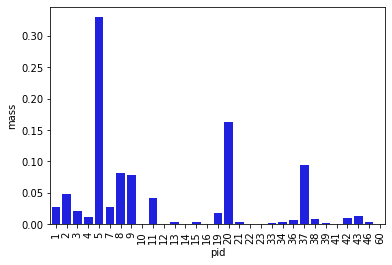

In [13]:
g = sns.barplot(x='pid', y='mass', data=df, ci=None, estimator=sum, color='blue')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g

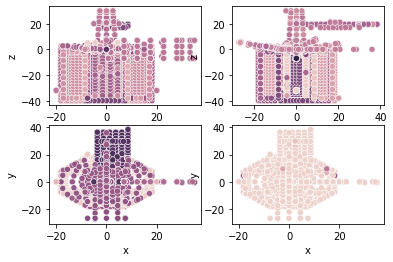

In [14]:
fig = plt.figure(figsize=(6,4))
sub1 = plt.subplot(2, 2, 1)
p1 = sns.scatterplot(data=df, x="x", y="z", hue="y", legend=False)
sub2 = plt.subplot(2, 2, 2)
p2 = sns.scatterplot(data=df, x="y", y="z", hue="x", legend=False)
sub3 = plt.subplot(2, 2, 3)
p3 = sns.scatterplot(data=df, x="x", y="y", hue="z", legend=False)
sub4 = plt.subplot(2, 2, 4)
p3 = sns.scatterplot(data=df, x="x", y="y", hue="mass", legend=False)

<AxesSubplot:xlabel='x_cat', ylabel='Count'>

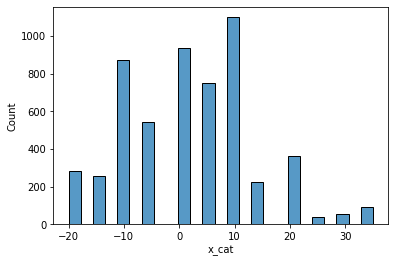

In [15]:
sns.histplot(data=df, x="x_cat")


<AxesSubplot:xlabel='x', ylabel='Count'>

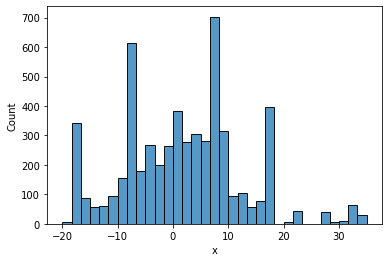

In [16]:
sns.histplot(data=df, x="x")

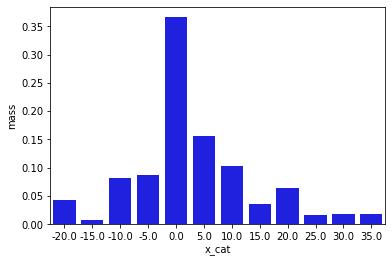

In [17]:
ax = sns.barplot(x='x_cat', y='mass', data=df, ci=None, estimator=sum, color='blue')

In [18]:
# x = sns.heatmap(data=df.mass, xticklabels=df.x, yticklabels=df.y, cmap="YlGnBu")

In [19]:
df.mean()

eid      2774.741445
pid        10.111534
mass        0.000181
x           1.799389
y           2.728231
z         -11.107283
x_cat       1.866739
y_cat       2.683324
z_cat     -11.100851
dtype: float64

In [20]:
df.max()

eid      5594.000000
pid        60.000000
mass        0.049524
x          35.000000
y          38.408110
z          30.000000
x_cat      35.000000
y_cat      40.000000
z_cat      30.000000
dtype: float64

In [21]:
df.min()

eid       1.000000
pid       1.000000
mass      0.000000
x       -20.000000
y       -27.471289
z       -40.000000
x_cat   -20.000000
y_cat   -25.000000
z_cat   -40.000000
dtype: float64

In [22]:
#to do:sns.histplot(data=df, x="mass") # doesnt work

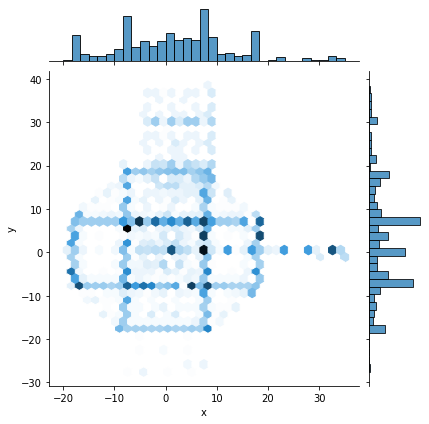

In [23]:
import numpy as np
plt

# Generate some test data
x = df.x
y = df.y

sns.jointplot(x=x, y=y, kind='hex')
plt.show()

In [ ]:
pandas.